<a href="https://colab.research.google.com/github/Alepescinaa/ScientificTools/blob/main/Lab_Ricky/Lab2/NeuralNetwork_ex3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercises: physics-informed neural network

Exercise on the implementation of physics-informed neural network.

Date: 2024

Course: 056936 - SCIENTIFIC COMPUTING TOOLS FOR ADVANCED MATHEMATICAL MODELLING (PAGANI STEFANO) [2023-24].

Example adapted from this [notebook](https://colab.research.google.com/drive/1qBrbgevkSBqqYc8bOPiaoJG1MBrBrluN?usp=share_link).


Let us consider the problem

\begin{aligned}
  & -\nu \Delta u = -2(x^2+y^2)  \,, \quad (x,y) \in [-1,1] \times [-1,1]\,,\\
  & u(x,-1) = u(x,1) = -x^2 \,, \quad -1 < x < 1\,, \\
  & u(-1,y) = u(1,y) = -y^2 \,, \quad -1 < y < 1\,, \\
\end{aligned}

where $\nu$ is unknown. We consider the PINN framework for solving the state/parameter estimation.

In [1]:
# import required libraries
import tensorflow as tf
import numpy as np
import scipy.io
from tensorflow import keras
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
!pip -q install pyDOE
from pyDOE import lhs  # for latin hypercube sampling

  Preparing metadata (setup.py) ... done


In [2]:
# set seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Solution

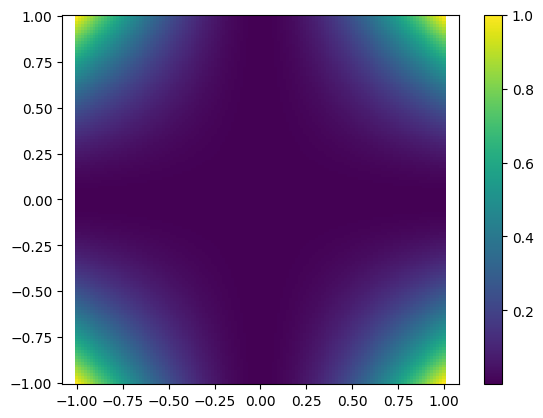

In [3]:
# plot exact solution
nu = 1.0 # diffusion parameter

# define grid for sampling the exact solution
N_h = 128
ux = np.linspace(-1.0,1.0,N_h)
uy = np.linspace (-1.0,1.0,N_h)

# sampling loop:
u_true = np.zeros([N_h,N_h])
for i in range(N_h):
    u_true[:,i] = (ux[i]**2)*(uy**2)

X_plot,Y_plot = np.meshgrid(ux,uy)
plt.pcolor(X_plot, Y_plot, u_true)
plt.axis('equal')
plt.colorbar()

In [4]:
# flatten grid and solution
X,Y = np.meshgrid(ux,uy)
X_flat = tf.convert_to_tensor(np.hstack((X.flatten()[:,None],Y.flatten()[:,None])),dtype=tf.float64)
u_flat = u_true.T.flatten()

In [ ]:
np.shape(u_true)

In [6]:
# PINN loss function
def loss(xcl,ycl,xmeas,ymeas,umeas,param):
    umeas_pred = PINN(tf.concat([xmeas,ymeas],1))
    r_pred   = r_PINN(xcl,ycl,param)

    # loss components
    mse_meas  = tf.reduce_mean(tf.pow(umeas-umeas_pred,2))
    mse_r  = tf.reduce_mean(tf.pow(r_pred,2))

    return mse_r+mse_meas # mse_0+mse_r+mse_lb+mse_ub

# neural network weight gradients
@tf.function
def grad(model,xcl,ycl,xmeas,ymeas,umeas, param):
    with tf.GradientTape(persistent=True) as tape:
        loss_value = loss(xcl,ycl,xmeas,ymeas,umeas, param)
        grads = tape.gradient(loss_value,model.trainable_variables)
        grad_param =  tape.gradient(loss_value,param)
    return loss_value, grads, grad_param

In [7]:
# collocation points
Ncl = 2000
X = lhs(2,Ncl)
xcl = tf.expand_dims(tf.cast(-1.0+(2.0)*X[:,0],dtype=tf.float64),axis=-1)
ycl = tf.expand_dims(tf.cast(-1.0+(2.0)*X[:,1],dtype=tf.float64),axis=-1)
X_coll = tf.concat([xcl,ycl],1)

# measurement points

Ncl = 20
X = lhs(2,Ncl)
xmeas = tf.expand_dims(tf.cast(-1.0+(2.0)*X[:,0],dtype=tf.float64),axis=-1)
ymeas = tf.expand_dims(tf.cast(-1.0+(2.0)*X[:,1],dtype=tf.float64),axis=-1)
X_meas = tf.concat([xmeas,ymeas],1)
umeas = (xmeas**2)*(ymeas**2)

Task 1: Test the accuracy of the reconstruction with respect to the optimization configurations and the number of layers.

In [8]:
# training loop

# initialize new instance of NN
PINN = tf.keras.Sequential([
    tf.keras.layers.Dense(8, activation='tanh', input_shape=(2,),kernel_initializer="glorot_normal",dtype=tf.float64),
    tf.keras.layers.Dense(32, activation='tanh',kernel_initializer="glorot_normal",dtype=tf.float64),
    tf.keras.layers.Dense(1,activation=None,kernel_initializer="glorot_normal",dtype=tf.float64)
])

In [9]:
# residual computation based on AD
@tf.function
def r_PINN(x,y,param):
    u    = PINN(tf.concat([x,y], 1))
    u_x  = tf.gradients(u,x)[0]
    u_xx = tf.gradients(u_x, x)[0]
    u_y  = tf.gradients(u,y)[0]
    u_yy = tf.gradients(u_y, y)[0]
    return - tf.exp(param) * ( u_xx + u_yy ) + 2.0*( tf.pow(x,2) + tf.pow(y,2) )


# Adam optimizer
tf_optimizer = tf.keras.optimizers.Adam(learning_rate=0.003,beta_1=0.99)

# parameter variable
param = tf.Variable(0.1,trainable=True,dtype=tf.float64)

for iter in range(20000):

  # compute gradients using AD
  loss_value,grads,grad_param = grad(PINN,xcl,ycl,xmeas,ymeas,umeas,param)

  # update neural network weights
  tf_optimizer.apply_gradients(zip(grads+[grad_param],PINN.trainable_variables+[param]))

  # display intermediate results
  if ((iter+1) % 200 == 0):
    print('iter =  '+str(iter+1))
    print('loss = {:.4f}'.format(loss_value))
    print('diffusion coefficient estimate = {:.4f}'.format(np.exp(param.numpy())))
    PINN_flat = PINN(X_flat)
    err = np.linalg.norm(u_flat-PINN_flat[:,-1],2)/np.linalg.norm(u_flat,2)
    print('L2 error: %.4e' % (err))

iter =  200
loss = 0.8671
diffusion coefficient estimate = 1.6818
L2 error: 6.2684e-01
iter =  400
loss = 0.4404
diffusion coefficient estimate = 2.1228
L2 error: 8.1290e-01
iter =  600
loss = 0.3749
diffusion coefficient estimate = 2.2657
L2 error: 7.3671e-01
iter =  800
loss = 0.3671
diffusion coefficient estimate = 2.2774
L2 error: 8.4338e-01
iter =  1000
loss = 0.3651
diffusion coefficient estimate = 2.2175
L2 error: 7.6501e-01
iter =  1200
loss = 0.3645
diffusion coefficient estimate = 2.1493
L2 error: 7.8603e-01
iter =  1400
loss = 0.3641
diffusion coefficient estimate = 2.0680
L2 error: 7.8328e-01
iter =  1600
loss = 0.3637
diffusion coefficient estimate = 1.9810
L2 error: 7.7974e-01
iter =  1800
loss = 0.3624
diffusion coefficient estimate = 1.8982
L2 error: 8.0297e-01
iter =  2000
loss = 0.1023
diffusion coefficient estimate = 2.1294
L2 error: 1.0781e+00
iter =  2200
loss = 0.0234
diffusion coefficient estimate = 2.5961
L2 error: 9.4333e-01
iter =  2400
loss = 0.0171
diffusion

Text(0.5, 1.0, 'L2 error = 0.0232')

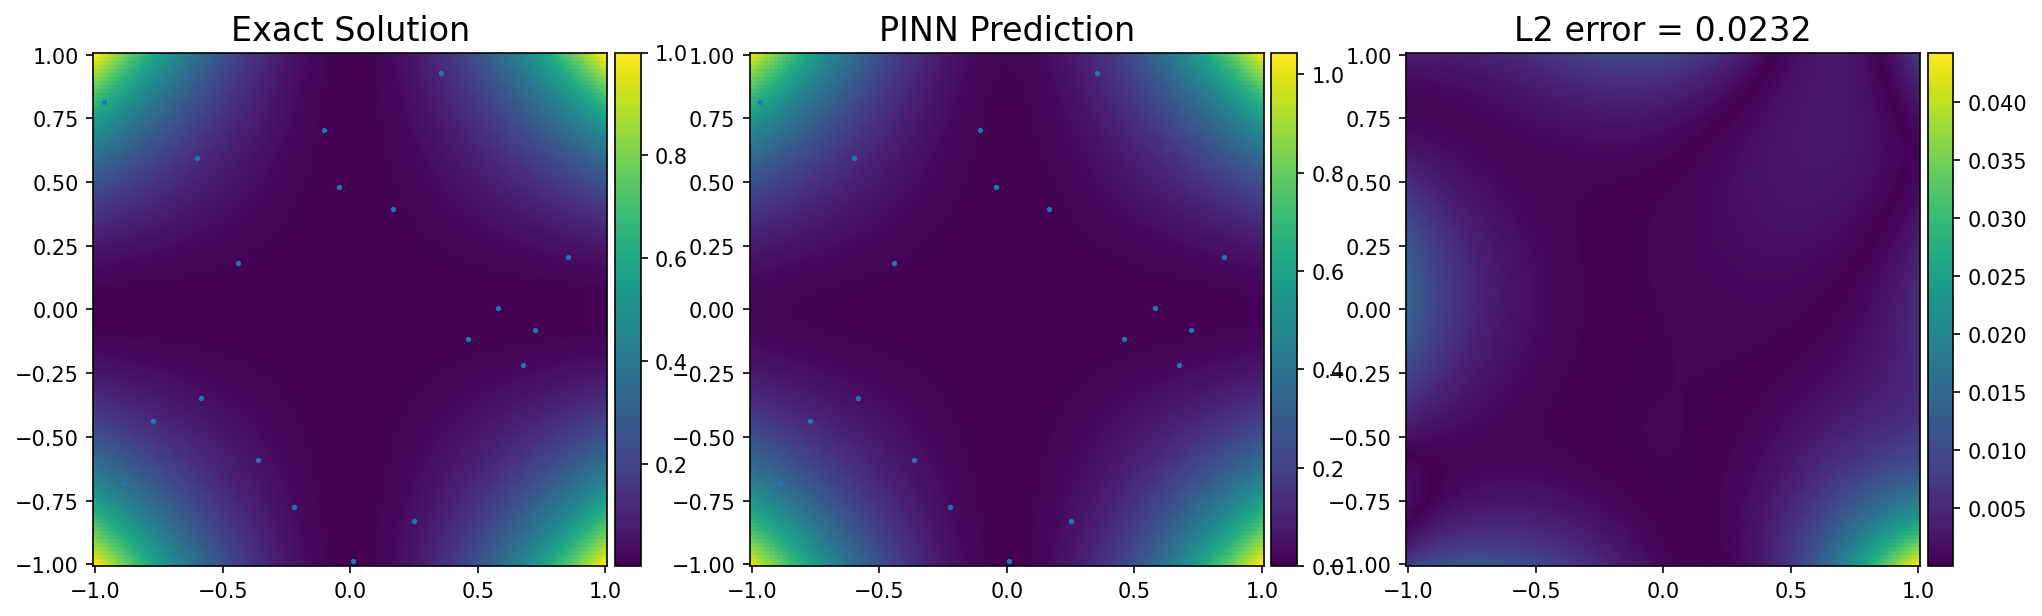

In [11]:
#Display results

fig = plt.figure(figsize=(16,9),dpi=150)
#fig = plt.figure()
#fig.subplots_adjust(wspace=0.3)
plt.style.use('default')
ax = fig.add_subplot(1,3,1)
ax.set_aspect(1)
im = plt.pcolor(X_plot, Y_plot, u_true)
plt.scatter(xmeas,ymeas,marker='x',s=3)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im,cax=cax)
#ax.set_yticklabels(['-1.0','-0.6','-0.2','0.2','0.6','1.0'])
ax.set_title('Exact Solution',fontsize=16)

ax = fig.add_subplot(1,3,2)
ax.set_aspect(1)
im = plt.pcolor(X_plot, Y_plot, np.reshape(PINN_flat,(N_h,N_h)))
plt.scatter(xmeas,ymeas,marker='x',s=3)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im,cax=cax)
ax.set_title('PINN Prediction'.format(err),fontsize=16)

ax = fig.add_subplot(1,3,3)
ax.set_aspect(1)
im = plt.pcolor(X_plot, Y_plot, np.abs( np.reshape(PINN_flat,(N_h,N_h)) -u_true ) )
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im,cax=cax)
ax.set_title('L2 error = {:.4f}'.format(err),fontsize=16)